In [1]:
from src.data import load_karate_club, load_cora_dataset
from src.experiments import show_karate_gt_vs_prediction, report_metrics, draw_dot_plot, rearrange_tau

from scipy.sparse.linalg import eigs
from scipy.sparse import diags, eye
from sklearn.cluster import KMeans

import networkx as nx
import numpy as np
import time
from matplotlib import pyplot as plt

/home/theilo/Software/Miniconda/envs/PGM/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/theilo/Software/Miniconda/envs/PGM/lib/python3.11/site-packages/graspologic/models/edge_swaps.py:215: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  _edge_swap_numba = nb.jit(_edge_swap, nopython=False)


# Spectral clustering method

In [2]:
def spectral_clustering(G, k):

    nb_nodes = G.number_of_nodes()
    adjacency_matrix = nx.adjacency_matrix(G)
    degree_sequence = np.array([G.degree(node) for node in G.nodes()])
    D_inv = diags(1/degree_sequence)
    laplacian =  eye(nb_nodes) - D_inv @ adjacency_matrix

    eigenvalues, eigenvectors = eigs(laplacian, k=k, which = "SM")
    U = np.real(eigenvectors)
    kmeans = KMeans(n_clusters = k).fit(U)
    labels = list(kmeans.labels_)

    return dict(zip(G.nodes(), labels))

# Zachary's Karate Club dataset

In [5]:
X, y = load_karate_club()
G = nx.from_numpy_array(X)
Q = 2

Number of nodes: 34
Number of edges: 78


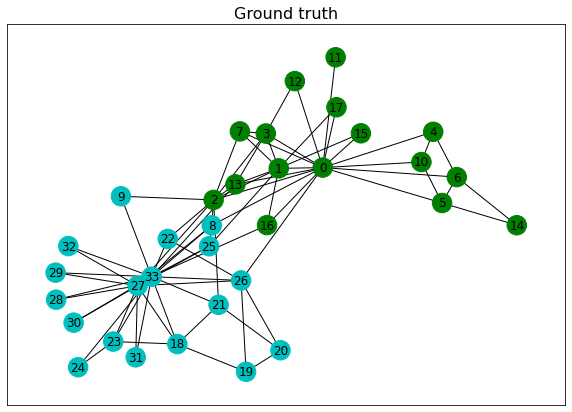

In [7]:
#Plot ground truth
pos = nx.spring_layout(G, seed=42)
plt.rcParams['figure.facecolor'] = 'white'
plt.figure(figsize=(10, 7))
color_list = ["g", "c", "r"]
node_colors = [color_list[i] for i in y]
nx.draw_networkx(G, node_color=node_colors, pos=pos, node_size=380)
plt.title("Ground truth", fontsize=16)
plt.savefig("images/karate_club_gt")

In [8]:
pred_clusters = spectral_clustering(G, Q).values()
# one hot encoding of predicted clusters
tau_pred = np.zeros((G.number_of_nodes(), Q))
for i, cluster in enumerate(pred_clusters):
    tau_pred[i, cluster] = 1

c:\Users\ezzeh\.julia\conda\3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


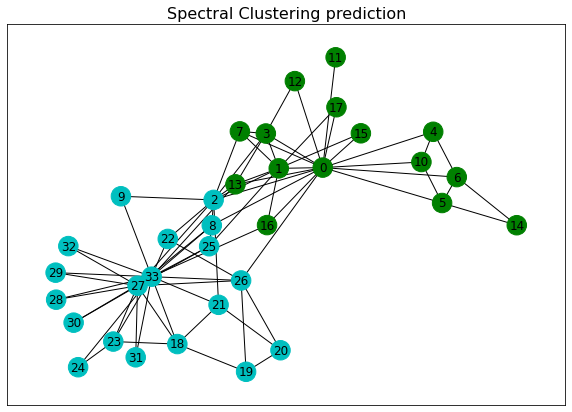

In [9]:
# Plot prediction
pos = nx.spring_layout(G, seed=42)
plt.rcParams['figure.facecolor'] = 'white'
plt.figure(figsize=(10, 7))
color_list = ["g", "c", "r"]
node_colors = [color_list[i] for i in np.argmax(tau_pred, axis=1)]
nx.draw_networkx(G, node_color=node_colors, pos=pos, node_size=380)
plt.title("Spectral Clustering prediction", fontsize=16)
plt.savefig("images/karate_club_spectral")

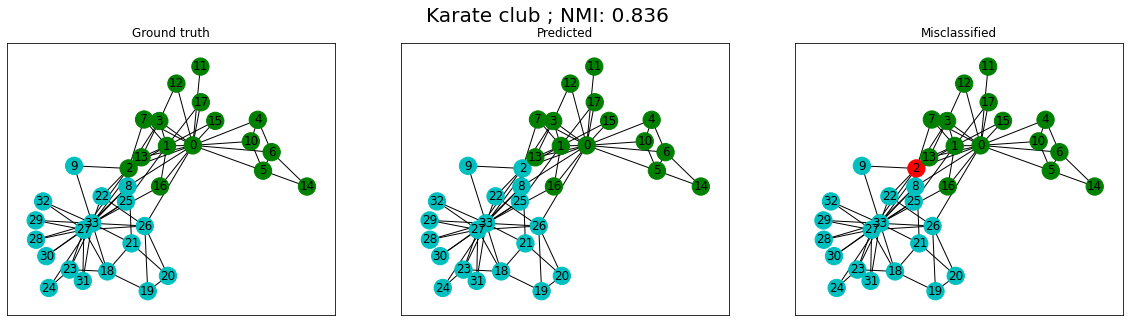

In [10]:
show_karate_gt_vs_prediction(G, tau_pred, y)

In [26]:
report_metrics(X, tau_pred, y, Q)

NMI: 0.836
Rand index: 0.941
Gt Modularity: 0.371
Pred Modularity: 0.360
Graph clustering coefficient: 0.2556818181818182
Per class gt clustering coefficients: [0.41899441340782123, 0.25961538461538464]
Per class pred clustering coefficients: [0.34782608695652173, 0.23949579831932774]


# Cora dataset

In [3]:
X, y = load_cora_dataset()
G = nx.from_numpy_array(X)
Q = 7

Number of nodes: 2708
Number of edges: 5278


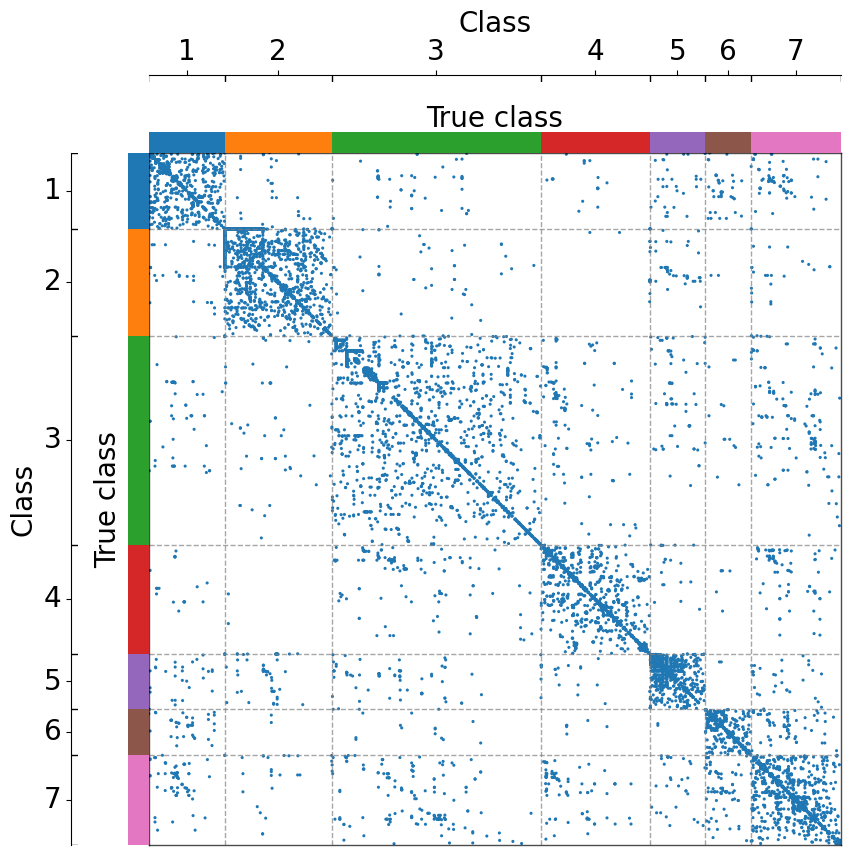

In [4]:
# Plot ground truth clustering
draw_dot_plot(X, y + 1, y + 1)

In [5]:
# Run EM algorithm
t0 = time.time()
pred_clusters = spectral_clustering(G, Q).values()
print("running time:", time.time() - t0)
# one hot encoding of predicted clusters
tau_pred = np.zeros((G.number_of_nodes(), Q))
for i, cluster in enumerate(pred_clusters):
    tau_pred[i, cluster] = 1

running time: 0.3286430835723877


/home/theilo/Software/Miniconda/envs/PGM/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


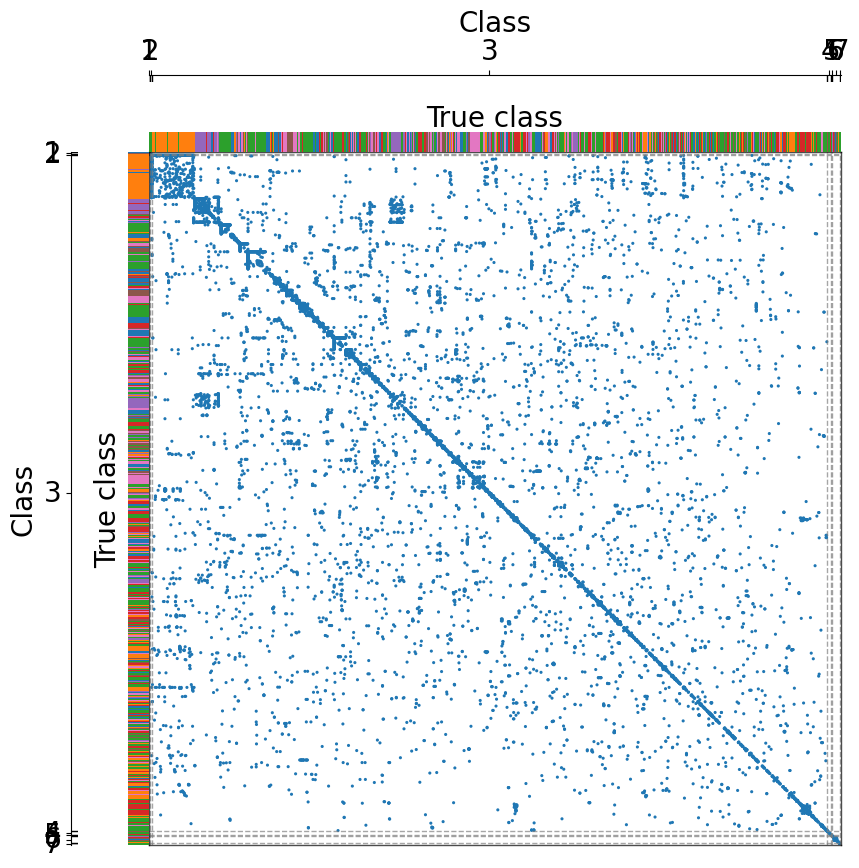

In [6]:
# Plot result
rearranged_tau_pred = rearrange_tau(tau_pred, y, Q=Q)
classification = rearranged_tau_pred.argmax(axis=1) + 1
draw_dot_plot(X, classification, y + 1, save_as="cora_spetral")

In [7]:
report_metrics(X, rearranged_tau_pred, y, Q)

NMI: 0.014
Rand index: 0.209
Gt Modularity: 0.640
Pred Modularity: 0.017
Graph clustering coefficient: 0.09349725626661058
Per class gt clustering coefficients: [0.18568665377176016, 0.05947263745428883, 0.12287887653598596, 0.2283628779979145, 0.10072090628218332, 0.22003577817531306, 0.1627731725697061]
Per class pred clustering coefficients: [0, 0, 0.09295693779904306, 0.0, 0, 0.66, 0]
